# Questão 3

Considere um problema de classificação de padrões constituído de oito padrões. A distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no círculo um losango também centrado na origem e com lados iguais a raiz de 2. Os dados das classe C1, C2, C3, C4 corresponde aos quatro setores do losango e as outras quatro classes correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto de treinamento e um conjunto de validação. Treine uma rede perceptron para classificar os padrões associados a cada uma das classes. Verifique o desempenho do classificador usando o conjunto de validação e calculando a matriz de confusão.

## Importações

Importando as bibliotecas que serão utilizadas na resolução do problema

In [1]:
# Biblioteca para funções estatísticas matemáticas
import statistics as st

# Biblioteca que possui funções para manipulação numérica de arrays e matrizes
import numpy as np

# Biblioteca para plotagem e manipulação de gráficos
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Biblioteca para utilização do medidor de acurácia
from sklearn.metrics import accuracy_score, confusion_matrix

# Biblioteca para preprocessar os dados por via do One Hot Encoder
from sklearn.preprocessing import OneHotEncoder

## Função de ativação

Função que transformará de forma não linear o sinal de entrada

In [2]:
# Implementação da função de ativação linear
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

# Implementação da função de ativação sigmoid
def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

# Implementação da função de ativação tanh
def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

# Implementação da função de ativação relu
def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

# Implementação da função de ativação leaky_relu
def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

# Implementação da função de ativação gaussian
def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Implementação da função de ativação degrau
def degrau(x, derivative=False):
    if derivative:
        np.where(x>0.5,1,1)
    return np.where(x>0.5,1,0)

# Implementação da função de ativação degrau
def step(x,derivative=False):
    if derivative:
        return np.where(x>0,1,1)
    return np.where(x>0,1,0)

## Função de custo

In [3]:
# Implementação da função de Erro Quadrático Médio
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

# Implementação da função Negative Log Likelihood
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

## Função de Suporte

In [4]:
# Implementação da função Softmax
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

same = lambda x: x
# tupla(x,limit)
threshold = lambda x: np.where(x[0]>x[1], 1, 0)

## Função de plotagem

Função usada para gerar o gráfico de épocas(x) vs erros(y)

In [5]:
def plot_error(data=[], label=['', ''], color=['blue', 'red']):
    plt.title("Erros de treino e validação")
    plt.xlabel("epochs")
    plt.ylabel("errors")
    plt.legend(handles=[mpatches.Patch(color=color[0], label=label[0]),
                        mpatches.Patch(color=color[1], label=label[1])])
    plt.plot(data[0], c=color[0])
    plt.plot(data[1], c=color[1])
    plt.show()

## Classe de Camada

Representa uma camada da rede guardando a entrada da mesma, pesos, biases, função de ativação e a saída da camada.

### Parâmetros

* <strong>dimensaoEntrada</strong>: dimensão dos dados de entrada da camada
* <strong>dimensaoSaida</strong>: dimensão dos dados de saida da camada
* <strong>func</strong>: função de ativação que será utilizada nos neurônios da rede
* <strong>use_bias</strong>: booleano para habilitar uso de bias

### Atributos

* <strong>x</strong>: dados de entrada da camada;
* <strong>w</strong>: matriz todos os pesos de todos os neutônios da camada;
* <strong>bias</strong>: vetor com os valores dos bias de todos os neurônios da camada;
* <strong>func</strong>: função de ativação que será utilizada nos neurônios da rede;
* <strong>entrFunc</strong>: armazena entrada da função de ativação;
* <strong>saidaFunc</strong>: armazena saída da função de ativação;
* <strong>dimensaoEntrada</strong>: dimensão dos dados de entrada da camada
* <strong>dimensaoPesos</strong>: dimensão dos dados de entrada da camada
* <strong>dimensaoBias</strong>: dimensão dos dados de entrada da camada
* <strong>use_bias</strong>: booleano para habilitar uso de bias

In [6]:
class Camada:
    def __init__(self, dimensaoEntrada, dimensaoSaida, func=step, use_bias=True):
        self.x = None
        self.w = np.random.randn(dimensaoSaida, dimensaoEntrada)
        self.bias = np.random.randn(1, dimensaoSaida)
        self.func = func
        self.entrFunc, self.saidaFunc = None, None
        self.dimensaoEntrada = dimensaoEntrada
        self.use_bias = use_bias
        self.dimensaoPesos, self.dimensaoBias = None, None
        self.dimensaoPesos, self._dimensaoBias, self._dimensaoBiasAnterior = None, None, 0.0

## Classe Rede Neural

Representa a rede neural em questão, nesse caso o Perceptron

### Atributos

* <strong>camadas</strong>: conjunto de camadas da rede
* <strong>calc_erro</strong>: métrica para calculo de erro
* <strong>learning_rate</strong>: taxa de aprendizagem da rede
* <strong>momentum</strong>: parametro para acelerar convergencia da função

In [7]:
class RedeNeural():
    def __init__(self, calc_erro=mse, learning_rate=1e-3, momentum=0.0):
        self.camadas = []
        self.calc_erro = calc_erro
        self.learning_rate = learning_rate
        self.momentum = momentum

    def treinar(self,
            X,
            Y,
            X_valid=None,
            Y_valid=None,
            epochs=1,
            batch_size=None,
            verbose=False,
            accuracy=True,
            one_hot=False):
        '''
            Função de treinamento
            Parâmetros:
                X - entradas
                Y - saídas esperadas
                epochs - quantidade de épocas de treinamento
                verbose - passos para verificação da época
        '''
        batch_size = X.shape[0] if batch_size is None else batch_size
        n_batches = X.shape[0] // batch_size
        error_track = []
        error_epoch = []
        error_valid_track = []
        
        for epoch in range(epochs+1):
            errors_batch = []
            for batch in range(n_batches):
                offset = batch_size * batch
                X_batch, Y_batch = X[offset:offset + batch_size], Y[offset:offset + batch_size]
                y_pred = self.processaNeuronio(X_batch)
                self.retropropagacao(Y_batch, y_pred)
                
                if one_hot:
                    Y_batch = np.argmax(Y_batch, axis=1)
                    y_pred = np.argmax(y_pred, axis=1)
                    
                errors_batch.append(np.mean(np.abs(Y_batch - y_pred)))
            
            error_track.append(np.mean(errors_batch))
            
            if accuracy:
                if one_hot:
                    y_pred = self.previsao(X_valid).argmax(axis=1)
                    error_valid_track.append(1 - accuracy_score(Y_valid, y_pred))
                else:
                    error_valid_track.append(1 - accuracy_score(Y_valid.astype('float'), self.previsao(X_valid).astype('float'))) 
            
            if epoch % verbose == 0:
                print('Epoch: {0}/{1} \nError: {2:0.4f}%'.format(epoch, epochs, error_track[-1] * 100))
                
        return error_track, error_valid_track
    
    def adicionaCamada(self, camada):
        '''
            Método para adição de layers ao modelo
            Parâmetros:
                layer - Layer a se adicionada ao modelo
        '''
        self.camadas.append(camada)
    
    def processaNeuronio(self, x):
        '''
            Método de Feedforward - Efetua a multiplicação das entradas pelos pesos, soma ao bias, aplica função de ativação
            Parâmetros:
                x - dados de entrada
        '''
        self.camadas[0].x = x
        for current_layer, next_layer in zip(self.camadas, self.camadas[1:] + [Camada(0,0)]):
            y = np.dot(current_layer.x, current_layer.w.T) + current_layer.bias
            current_layer.entrFunc = y
            current_layer.saidaFunc = next_layer.x = current_layer.func(y)
        return self.camadas[-1].saidaFunc
    
    def previsao(self, X, verbose=False):
        '''
            Método de Predição - Gera um conjunto de valores resultante do processo de FeedForward nos para os dados de entrada
            Parâmetros:
                x - dados de entrada
        '''
        return self.processaNeuronio(X)
    
    def validar(self, y_pred, y, func=step, dtype=int):
        '''
            Método Evaluate - Verifica a accuracy da rede
            Parâmetros:
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
                dtype - tipo dos dados
        '''
        score = 0
        total = 100.0/y.shape[0]
        y_pred = y_pred.astype(dtype)
        y = y.astype(dtype)

        for y_i, y_pred_i in zip(y,y_pred):
            y_pred_i = func(y_pred_i)
            if np.array_equal(y_i,y_pred_i):
                score+=1
        return score*total

    def retropropagacao(self, y, y_pred):
        '''
            Método para a aplicação do backpropagation
            Parâmetros:
                y - dados de saída esperados
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
        '''
        last_delta = self.calc_erro(y, y_pred, derivative=True)
        for layer in reversed(self.camadas):
            dactivation = layer.func(layer.entrFunc, derivative=True)*last_delta
            last_delta = np.dot(dactivation, layer.w)
            layer.dimensaoPesos = np.dot(dactivation.T, layer.x)
            layer.dimensaoBias = 1.0*dactivation.sum(axis=0, keepdims=True)

        for layer in reversed(self.camadas):
            layer._dimensaoBiasAnterior = -self.learning_rate*layer.dimensaoPesos + self.momentum*layer._dimensaoBiasAnterior
            layer.w = layer.w + layer._dimensaoBiasAnterior
            layer.biases = layer.bias - self.learning_rate*layer.dimensaoBias

## Fluxo de execução da Main

Representará a inicialização e execução da rede neural.

<strong>Fluxo</strong>: Primeiramente a rede é inicializada, em seguida os dados de entrada e saida são obtidos, logo após o treinamento é feito com 80% dos dados e o Teste com os 20% restantes, e por fim a acuracia da rede é verificada

X [TREINO]:  (6242, 2)
Y [TREINO]:  (6242, 1)

X [TESTE]:  (1249, 2)
Y [TESTE]:  (1249, 1)


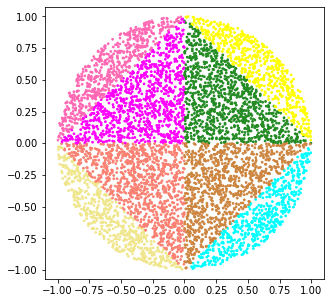

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data_x.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data_y.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

print("X [TREINO]: ", x.shape)
print("Y [TREINO]: ", y.shape)
print()
print("X [TESTE]: ", x_valid.shape)
print("Y [TESTE]: ", y_valid.shape)

colors = {0:'salmon', 1:'peru', 2:'magenta', 3:'forestgreen', 4:'khaki', 5:'aqua', 6:'hotpink', 7:'yellow'}

plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s = 3, c=[colors[int(yp[0])] for yp in y])
plt.axis('equal')
plt.show()

onehot = OneHotEncoder(sparse=False)
y_oh = onehot.fit_transform(y)

## Modelo de Arquitetura
  
**Parâmetros:**
* Learning Rate: 0.01
* Layers: 2
* Momentum: 0.9

**Layer1:**
* Dimensão de Entrada: 2
* Dimensão de Saída: 20
* Função de Ativação: linear

**Layer2:**
* Dimensão de Entrada: 20
* Dimensão de Saída: 8
* Função de Ativação: linear

**Treinamento:**
* Épocas: 10000


  

Epoch: 0/10000 
Error: 391.5091%
Epoch: 500/10000 
Error: 1.5380%
Epoch: 1000/10000 
Error: 1.2496%
Epoch: 1500/10000 
Error: 1.0253%
Epoch: 2000/10000 
Error: 1.0093%
Epoch: 2500/10000 
Error: 0.8651%
Epoch: 3000/10000 
Error: 0.8331%
Epoch: 3500/10000 
Error: 0.8331%
Epoch: 4000/10000 
Error: 0.7049%
Epoch: 4500/10000 
Error: 0.6889%
Epoch: 5000/10000 
Error: 0.5928%
Epoch: 5500/10000 
Error: 0.5928%
Epoch: 6000/10000 
Error: 0.5928%
Epoch: 6500/10000 
Error: 0.5928%
Epoch: 7000/10000 
Error: 0.5607%
Epoch: 7500/10000 
Error: 0.5607%
Epoch: 8000/10000 
Error: 0.5607%
Epoch: 8500/10000 
Error: 0.5447%
Epoch: 9000/10000 
Error: 0.5447%
Epoch: 9500/10000 
Error: 0.5447%
Epoch: 10000/10000 
Error: 0.6088%


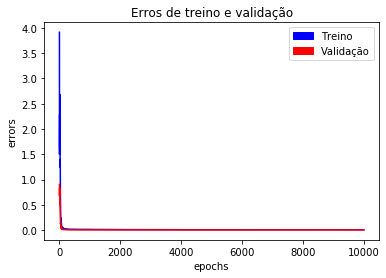

Matriz de confusão: 

    1   2   3   4   5   6   7   8
1 [212   3   0   0   0   0   0   0]
2 [  0 179   0   0   0   0   0   0]
3 [  0   0 212   0   0   0   0   0]
4 [  0   0   0 189   0   0   0   0]
5 [  1   0   0   0 114   0   0   0]
6 [ 0  0  0  0  0 93  0  0]
7 [  0   0   0   0   0   0 130   0]
8 [  0   0   0   0   0   0   0 116]


In [13]:
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.1, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=linear))
nn.add_layer(Layer(input_dim=20, output_dim=y_oh.shape[1], activation=linear))

# treinamento
errors_train, errors_valid = nn.fit(x, y_oh, x_valid, y_valid, epochs=10000, verbose=500, one_hot=True)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# prediction
y_pred = nn.predict(x_valid).argmax(axis=1)
accuracy_score(y_valid, y_pred)

print("Matriz de confusão: \n")

confMatrix = confusion_matrix(y_valid, y_pred)

print('   ', '   '.join([str(i+1) for i in range(len(confMatrix))]))

for index, confusion in enumerate(confMatrix):
    print(index + 1, confusion)